In [1]:
#!pip install mgwr

In [50]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
plt.style.use('ggplot') # specifies that graphs should use ggplot styling
%matplotlib inline

import os
import json
import numpy as np
import geopandas as gpd
import re
import string
import unicodedata
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from matplotlib import figure
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import shift_colormap, truncate_colormap
import libpysal as ps
import matplotlib as mpl
import mapclassify

In [3]:
#!pip install geopandas

# **Load the Data**

## MSOA

In [43]:
msoas = gpd.read_file('statistical-gis-boundaries-london/ESRI/MSOA/MSOA_2011_London_gen_MHW.shp')

<AxesSubplot:>

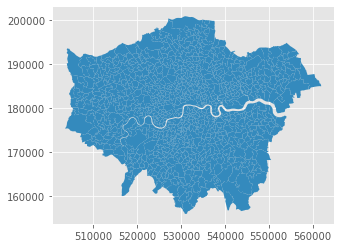

In [45]:
msoas.plot()

In [46]:
msoas.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 13 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   MSOA11CD   983 non-null    object  
 1   MSOA11NM   983 non-null    object  
 2   LAD11CD    983 non-null    object  
 3   LAD11NM    983 non-null    object  
 4   RGN11CD    983 non-null    object  
 5   RGN11NM    983 non-null    object  
 6   USUALRES   983 non-null    int64   
 7   HHOLDRES   983 non-null    int64   
 8   COMESTRES  983 non-null    int64   
 9   POPDEN     983 non-null    float64 
 10  HHOLDS     983 non-null    int64   
 11  AVHHOLDSZ  983 non-null    float64 
 12  geometry   983 non-null    geometry
dtypes: float64(2), geometry(1), int64(4), object(6)
memory usage: 100.0+ KB


## Housing Price

In [4]:
cols = ['Code','Area','Housing_Average','Housing_Median'] 
df_housing = pd.read_csv('Data/housingprice_MSOA_mean_median_2017average_0816new.csv', usecols = cols)
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Code             983 non-null    object 
 1   Area             983 non-null    object 
 2   Housing_Average  983 non-null    float64
 3   Housing_Median   983 non-null    float64
dtypes: float64(2), object(2)
memory usage: 30.8+ KB


In [34]:
df_housing['Housing_Average'].describe()

count                                   983.0000
mean                                595,209.3596
std                                 381,420.1873
min                                 225,405.0000
25%                                 379,611.3750
50%                                 487,423.7500
75%                                 664,207.2500
max                               4,348,686.5000
Name: Housing_Average, dtype: float64

<AxesSubplot:>

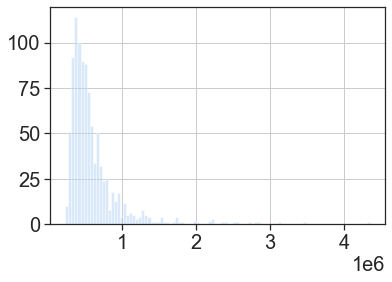

In [77]:
df_housing['Housing_Average'].hist(bins = 100,color="b", histtype="bar", rwidth=10, alpha=0.4)

#### PLOT

In [48]:
# merge the data
msoa_housing = pd.merge(msoas, df_housing, left_on = 'MSOA11CD', right_on = 'Code', how = 'inner')
msoa_housing.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 983 entries, 0 to 982
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   MSOA11CD         983 non-null    object  
 1   MSOA11NM         983 non-null    object  
 2   LAD11CD          983 non-null    object  
 3   LAD11NM          983 non-null    object  
 4   RGN11CD          983 non-null    object  
 5   RGN11NM          983 non-null    object  
 6   USUALRES         983 non-null    int64   
 7   HHOLDRES         983 non-null    int64   
 8   COMESTRES        983 non-null    int64   
 9   POPDEN           983 non-null    float64 
 10  HHOLDS           983 non-null    int64   
 11  AVHHOLDSZ        983 non-null    float64 
 12  geometry         983 non-null    geometry
 13  Code             983 non-null    object  
 14  Area             983 non-null    object  
 15  Housing_Average  983 non-null    float64 
 16  Housing_Median   983 non-null    flo

<ipython-input-62-706690ba0e64>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = cbar.ax.set_yticklabels(bins)


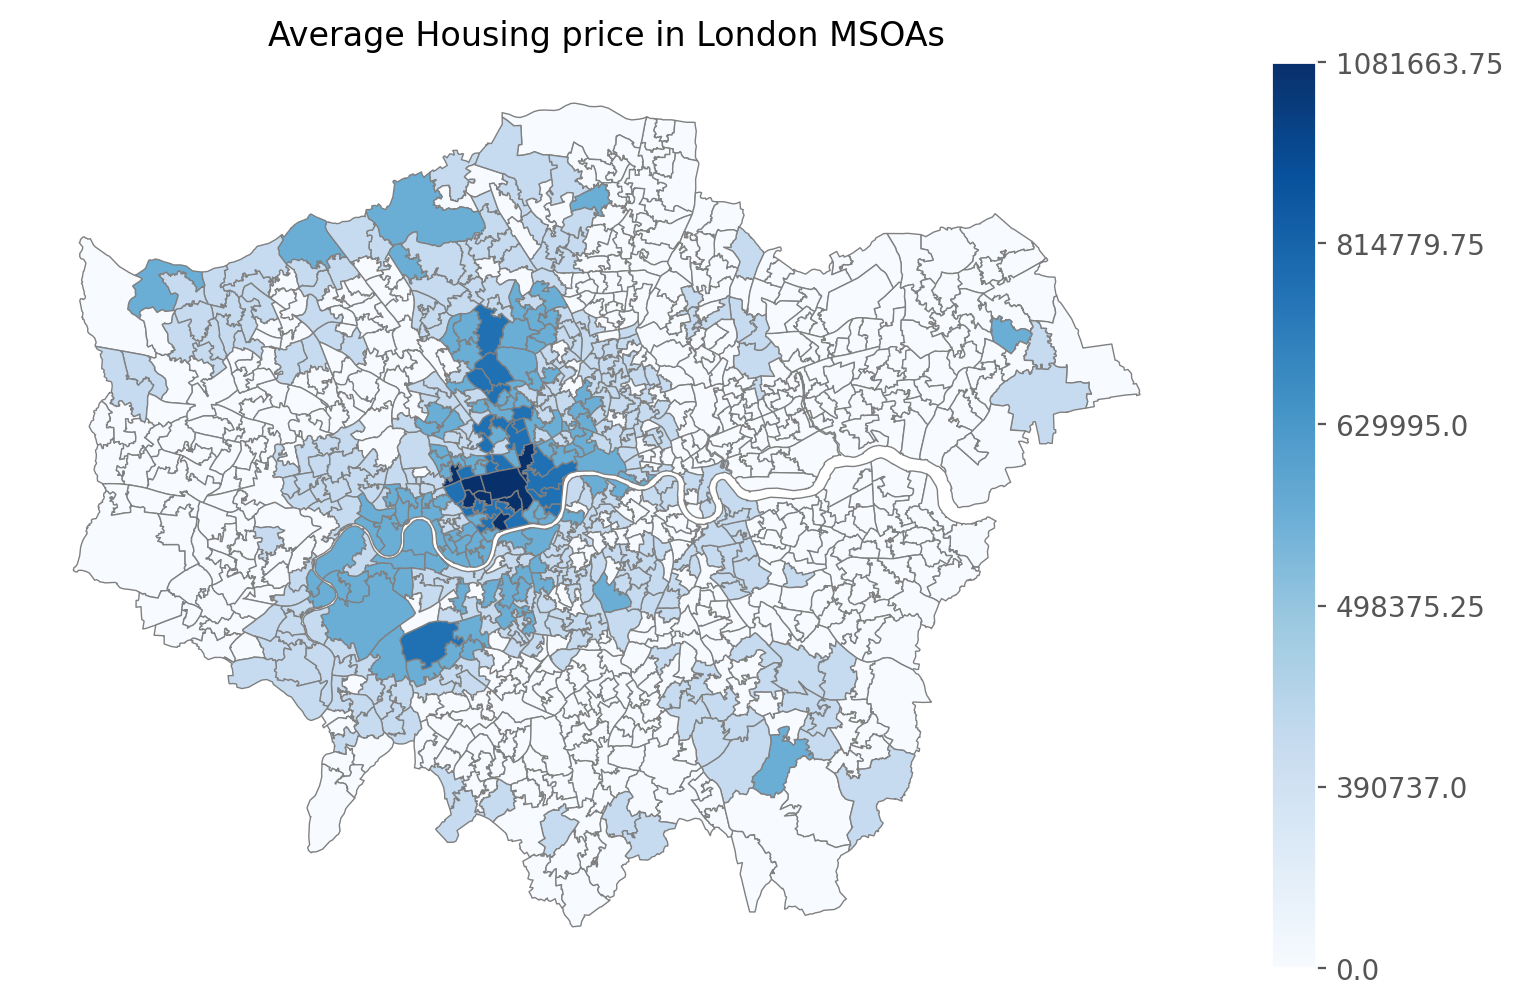

In [62]:
def map_airbnb_price():
    
    fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)
    
    msoa_housing.plot(column='Housing_Average', cmap='Blues', scheme='FisherJenks',
                            linewidth=0.5, edgecolor='0.5', ax=ax)

    ax.axis('off')

    # Create colorbar as a legend 
    sm = plt.cm.ScalarMappable(cmap='Blues')
    # add the colorbar to the figure 
    cbar = fig.colorbar(sm)
    bins = mapclassify.FisherJenks(msoa_housing['Housing_Average'], 10).bins
    bins = np.insert(bins, 0, 0)
    _ = cbar.ax.set_yticklabels(bins)

    ax.set_title('Average Housing price in London MSOAs', fontdict={
        'fontsize': '12', 'fontweight': '1'})
    
map_airbnb_price()

## Centrality

### Closeness with weight

In [5]:
cols = ['MSOA11CD','MSOA11NM','CC_w_MSOA']
df_cc_w = pd.read_csv('Data/CC_w_MSOA.csv', usecols = cols)
df_cc_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MSOA11CD   979 non-null    object 
 1   MSOA11NM   979 non-null    object 
 2   CC_w_MSOA  979 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.1+ KB


In [35]:
df_cc_w['CC_w_MSOA'].describe()

count                                   979.0000
mean                                      4.8116
std                                       0.8690
min                                       2.6985
25%                                       4.1236
50%                                       4.8081
75%                                       5.5752
max                                       6.4468
Name: CC_w_MSOA, dtype: float64

In [63]:
# merge the data
msoa_cc = pd.merge(msoas, df_cc_w, left_on = 'MSOA11CD', right_on = 'MSOA11CD', how = 'inner')
msoa_cc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MSOA11CD    979 non-null    object  
 1   MSOA11NM_x  979 non-null    object  
 2   LAD11CD     979 non-null    object  
 3   LAD11NM     979 non-null    object  
 4   RGN11CD     979 non-null    object  
 5   RGN11NM     979 non-null    object  
 6   USUALRES    979 non-null    int64   
 7   HHOLDRES    979 non-null    int64   
 8   COMESTRES   979 non-null    int64   
 9   POPDEN      979 non-null    float64 
 10  HHOLDS      979 non-null    int64   
 11  AVHHOLDSZ   979 non-null    float64 
 12  geometry    979 non-null    geometry
 13  MSOA11NM_y  979 non-null    object  
 14  CC_w_MSOA   979 non-null    float64 
dtypes: float64(3), geometry(1), int64(4), object(7)
memory usage: 122.4+ KB


<ipython-input-69-5a927e512e11>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = cbar.ax.set_yticklabels(bins)


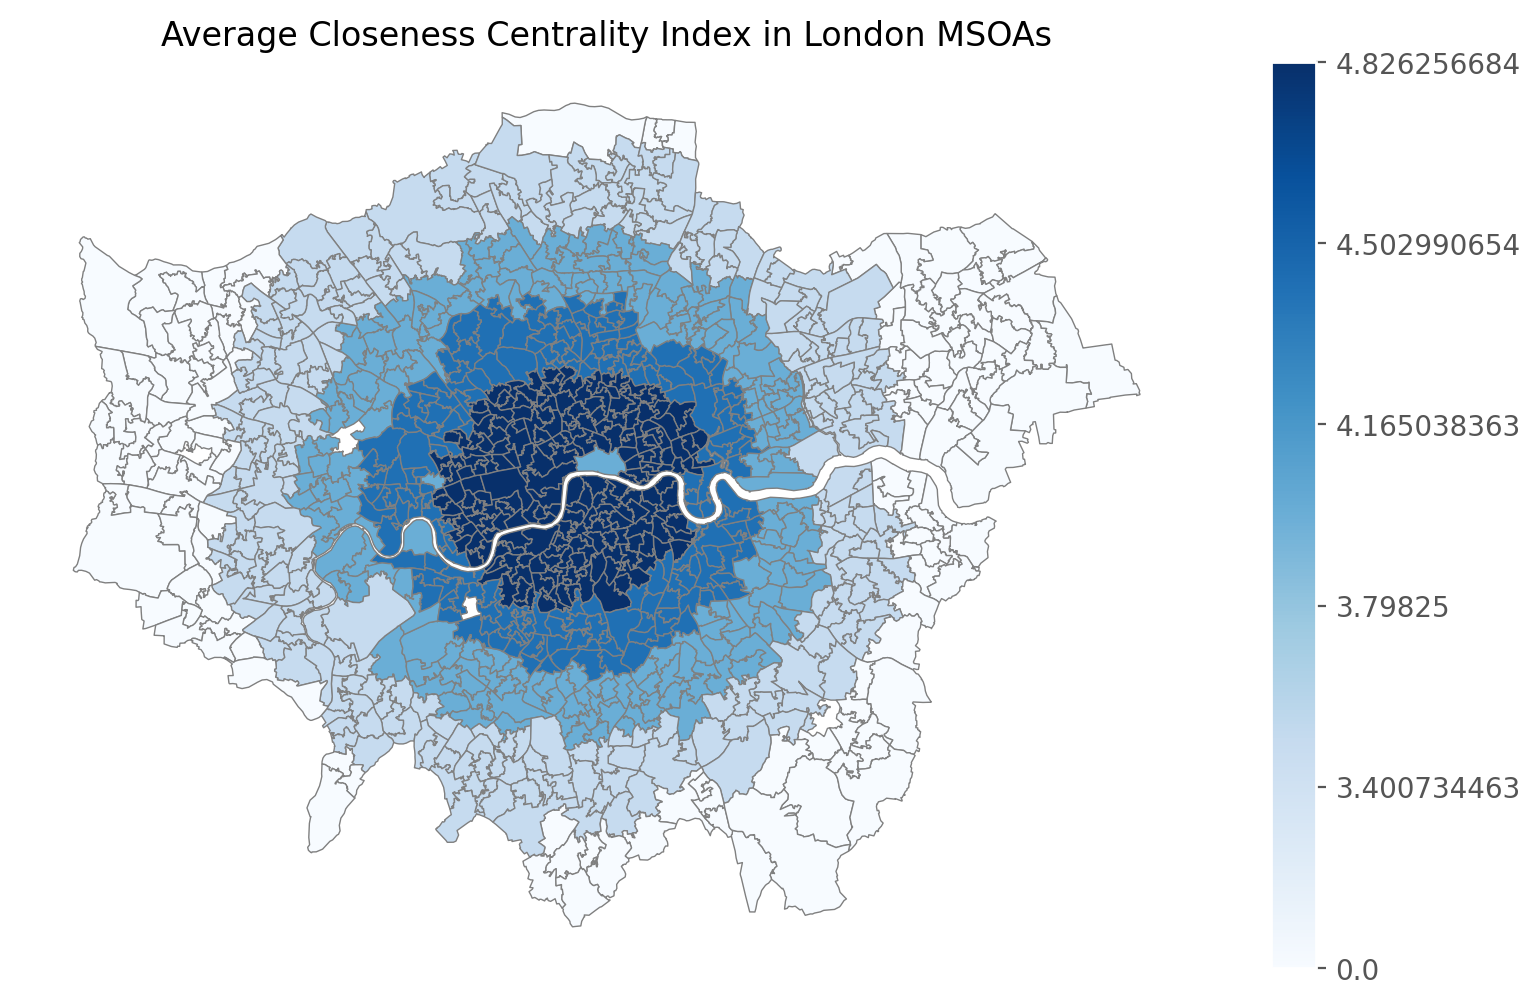

In [69]:
def map_airbnb_price():
    
    fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)
    
    msoa_cc.plot(column='CC_w_MSOA', cmap='Blues', scheme='FisherJenks',
                            linewidth=0.5, edgecolor='0.5', ax=ax)

    ax.axis('off')

    # Create colorbar as a legend 
    sm = plt.cm.ScalarMappable(cmap='Blues')
    # add the colorbar to the figure 
    cbar = fig.colorbar(sm)
    bins = mapclassify.FisherJenks(msoa_cc['CC_w_MSOA'], 10).bins
    bins = np.insert(bins, 0, 0)
    _ = cbar.ax.set_yticklabels(bins)

    ax.set_title('Average Closeness Centrality Index in London MSOAs', fontdict={
        'fontsize': '12', 'fontweight': '1'})
    
map_airbnb_price()

### Betweenness with weight

In [6]:
cols = ['MSOA11CD','MSOA11NM','BC_w_MSOA']
df_bc_w = pd.read_csv('Data/BC_w_MSOA.csv', usecols = cols)
df_bc_w.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   MSOA11CD   979 non-null    object 
 1   MSOA11NM   979 non-null    object 
 2   BC_w_MSOA  979 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.1+ KB


In [36]:
df_bc_w['BC_w_MSOA'].describe()

count                                   979.0000
mean                             37,235,174.3817
std                              35,028,637.9197
min                                 302,024.3750
25%                              12,822,733.4450
50%                              26,539,949.6600
75%                              49,984,764.2550
max                             295,932,693.1000
Name: BC_w_MSOA, dtype: float64

In [66]:
# merge the data
msoa_bc = pd.merge(msoas, df_bc_w, left_on = 'MSOA11CD', right_on = 'MSOA11CD', how = 'inner')
msoa_bc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MSOA11CD    979 non-null    object  
 1   MSOA11NM_x  979 non-null    object  
 2   LAD11CD     979 non-null    object  
 3   LAD11NM     979 non-null    object  
 4   RGN11CD     979 non-null    object  
 5   RGN11NM     979 non-null    object  
 6   USUALRES    979 non-null    int64   
 7   HHOLDRES    979 non-null    int64   
 8   COMESTRES   979 non-null    int64   
 9   POPDEN      979 non-null    float64 
 10  HHOLDS      979 non-null    int64   
 11  AVHHOLDSZ   979 non-null    float64 
 12  geometry    979 non-null    geometry
 13  MSOA11NM_y  979 non-null    object  
 14  BC_w_MSOA   979 non-null    float64 
dtypes: float64(3), geometry(1), int64(4), object(7)
memory usage: 122.4+ KB


<ipython-input-67-c8f0fb337a45>:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = cbar.ax.set_yticklabels(bins)


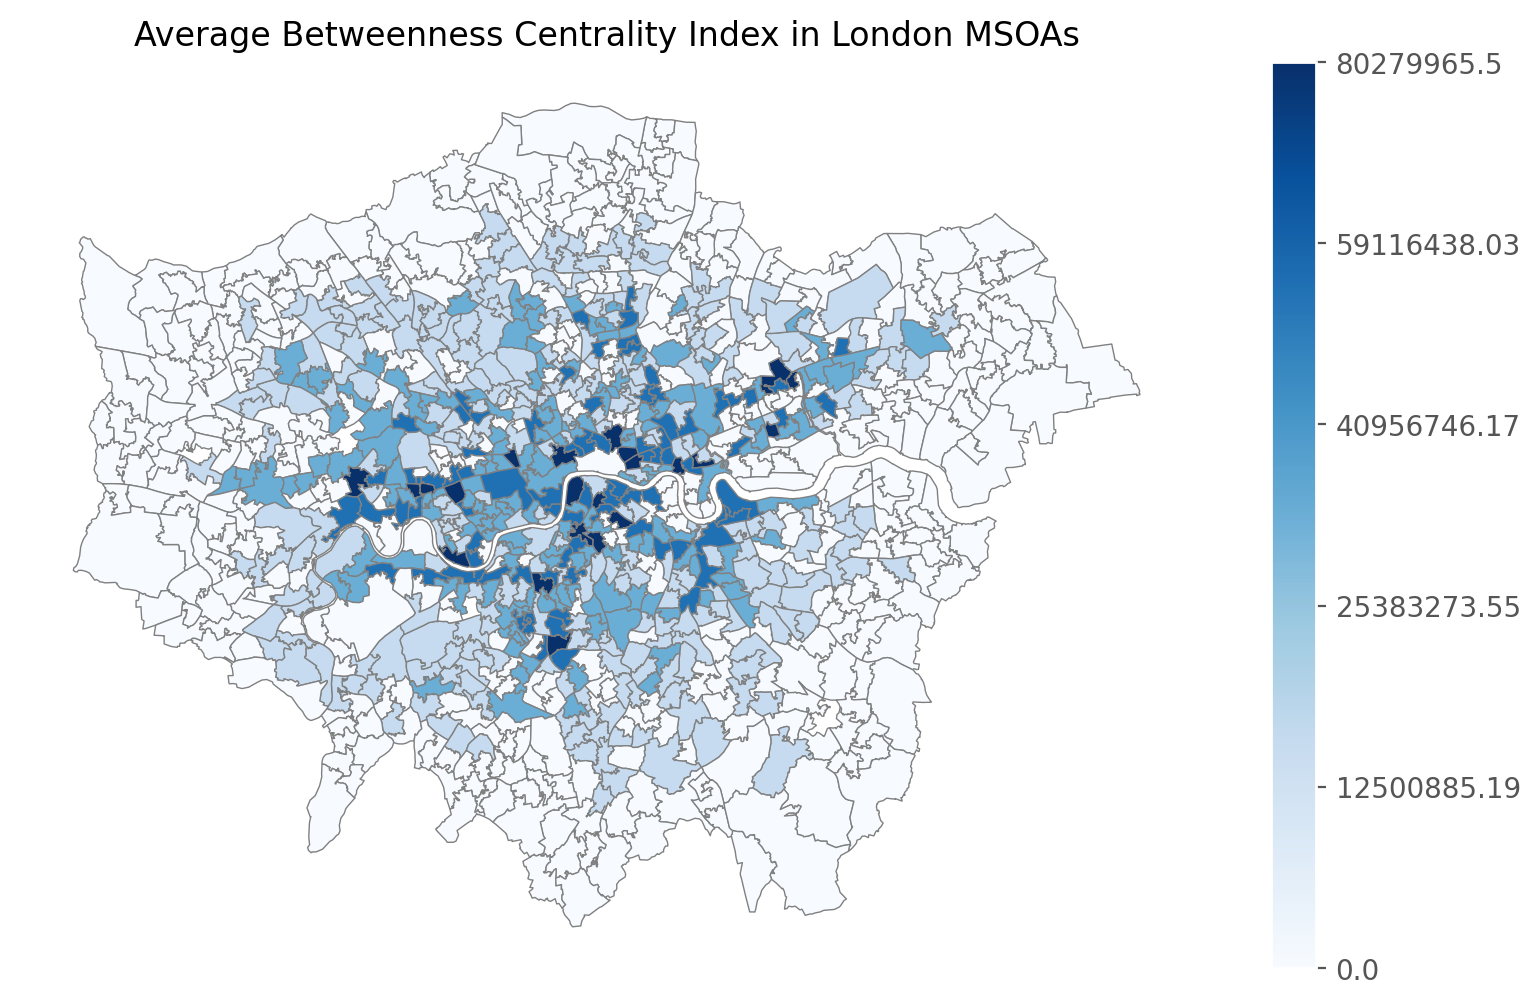

In [67]:
def map_airbnb_price():
    
    fig, ax = plt.subplots(1, figsize=(10, 6), dpi=200)
    
    msoa_bc.plot(column='BC_w_MSOA', cmap='Blues', scheme='FisherJenks',
                            linewidth=0.5, edgecolor='0.5', ax=ax)

    ax.axis('off')

    # Create colorbar as a legend 
    sm = plt.cm.ScalarMappable(cmap='Blues')
    # add the colorbar to the figure 
    cbar = fig.colorbar(sm)
    bins = mapclassify.FisherJenks(msoa_bc['BC_w_MSOA'], 10).bins
    bins = np.insert(bins, 0, 0)
    _ = cbar.ax.set_yticklabels(bins)

    ax.set_title('Average Betweenness Centrality Index in London MSOAs', fontdict={
        'fontsize': '12', 'fontweight': '1'})
    
map_airbnb_price()

## Air Quality & Crime Rate

In [7]:
cols = ['MSOA Code', 'MSOA Name', 'crime_rate', 'NOx_index']
df_air_crime = pd.read_csv('Data/Crime_Air_MSOA.csv', usecols = cols)
df_air_crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MSOA Code   983 non-null    object 
 1   MSOA Name   984 non-null    object 
 2   crime_rate  983 non-null    float64
 3   NOx_index   983 non-null    float64
dtypes: float64(2), object(2)
memory usage: 30.9+ KB


In [37]:
df_air_crime['crime_rate'].describe()

count                                   983.0000
mean                                     85.8238
std                                      98.4891
min                                      19.0000
25%                                      54.0000
50%                                      70.0000
75%                                      91.0000
max                                   1,934.0000
Name: crime_rate, dtype: float64

In [38]:
df_air_crime['NOx_index'].describe()

count                                   983.0000
mean                                     99.9196
std                                      22.6186
min                                      57.0000
25%                                      84.0000
50%                                      96.0000
75%                                     112.5000
max                                     203.0000
Name: NOx_index, dtype: float64

## Schools

In [8]:
cols = ['MSOA11CD', 'MSOA11NM', 'Num_Schools_MSOA']
df_schools = pd.read_csv('Data/LondonSchools_MSOA_counts.csv', usecols = cols)
df_schools.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 979 entries, 0 to 978
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   MSOA11CD          979 non-null    object
 1   MSOA11NM          979 non-null    object
 2   Num_Schools_MSOA  979 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 23.1+ KB


In [39]:
df_schools['Num_Schools_MSOA'].describe()

count                                   979.0000
mean                                      3.4321
std                                       2.2375
min                                       0.0000
25%                                       2.0000
50%                                       3.0000
75%                                       4.0000
max                                      22.0000
Name: Num_Schools_MSOA, dtype: float64

## Distance between the MSOA

In [9]:
df_MSOA_distance = pd.read_csv('Data/Distance_to_Centre_MSOA.csv')
df_MSOA_distance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         983 non-null    object 
 1   E02000001  983 non-null    float64
dtypes: float64(1), object(1)
memory usage: 15.5+ KB


In [40]:
df_MSOA_distance['E02000001'].describe()

count                                   983.0000
mean                                 12,486.2232
std                                   5,905.8129
min                                       0.0000
25%                                   7,935.0826
50%                                  12,111.8072
75%                                  16,988.1693
max                                  28,214.6733
Name: E02000001, dtype: float64

## Green & Blue Rate

In [10]:
cols = ['MSOA11CD', 'MSOA11NM', 'percent_green_blue']
df_green = pd.read_csv('Data/London_Green_Blue_Rate_MSOA.csv', usecols = cols)
df_green.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MSOA11CD            983 non-null    object 
 1   MSOA11NM            983 non-null    object 
 2   percent_green_blue  983 non-null    float64
dtypes: float64(1), object(2)
memory usage: 23.2+ KB


In [41]:
df_green['percent_green_blue'].describe()

count                                   983.0000
mean                                     43.5192
std                                      15.1241
min                                       5.7417
25%                                      32.7754
50%                                      42.1071
75%                                      52.3588
max                                      89.3302
Name: percent_green_blue, dtype: float64

## House Age

In [11]:
df_age = pd.read_csv('Data/MSOA_HOUSE_AGE_concise.csv')
df_age

,MSOA_CODE,MSOA_NAME,ALL_PROPERTIES_ACTUAL,AVERAGE_AGE
0,E02000002,Barking and Dagenham 001,644,60.2842
1,E02000002,Barking and Dagenham 001,660,58.6818
2,E02000002,Barking and Dagenham 001,671,69.5641
3,E02000002,Barking and Dagenham 001,792,65.2891
4,E02000003,Barking and Dagenham 002,631,77.7433
...,...,...,...,...
4830,E02000983,Westminster 024,760,78.4276
4831,E02000983,Westminster 024,781,53.3060
4832,E02000983,Westminster 024,732,101.7336
4833,E02000983,Westminster 024,1141,89.8576


In [12]:
#group by the MSOA and calculate the average
df_age = df_age.groupby(['MSOA_CODE']).mean().reset_index()
df_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983 entries, 0 to 982
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MSOA_CODE              983 non-null    object 
 1   ALL_PROPERTIES_ACTUAL  983 non-null    float64
 2   AVERAGE_AGE            983 non-null    float64
dtypes: float64(2), object(1)
memory usage: 23.2+ KB


In [42]:
df_age['AVERAGE_AGE'].describe()

count                                   983.0000
mean                                     79.9600
std                                      16.4179
min                                      22.9780
25%                                      69.7908
50%                                      79.9460
75%                                      90.9849
max                                     118.8863
Name: AVERAGE_AGE, dtype: float64

# **Data Merging**

In [13]:
df_housing_cc = pd.merge(df_housing, df_cc_w, left_on = 'Code', right_on = 'MSOA11CD', how = 'inner')
df_housing_cc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Code             979 non-null    object 
 1   Area             979 non-null    object 
 2   Housing_Average  979 non-null    float64
 3   Housing_Median   979 non-null    float64
 4   MSOA11CD         979 non-null    object 
 5   MSOA11NM         979 non-null    object 
 6   CC_w_MSOA        979 non-null    float64
dtypes: float64(3), object(4)
memory usage: 61.2+ KB


In [14]:
df_housing_cc.drop(columns=['MSOA11CD','MSOA11NM'], inplace=True)
df_housing_cc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Code             979 non-null    object 
 1   Area             979 non-null    object 
 2   Housing_Average  979 non-null    float64
 3   Housing_Median   979 non-null    float64
 4   CC_w_MSOA        979 non-null    float64
dtypes: float64(3), object(2)
memory usage: 45.9+ KB


In [15]:
df_housing_cc_bc = pd.merge(df_housing_cc, df_bc_w, left_on = 'Code', right_on = 'MSOA11CD', how = 'inner')
df_housing_cc_bc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Code             979 non-null    object 
 1   Area             979 non-null    object 
 2   Housing_Average  979 non-null    float64
 3   Housing_Median   979 non-null    float64
 4   CC_w_MSOA        979 non-null    float64
 5   MSOA11CD         979 non-null    object 
 6   MSOA11NM         979 non-null    object 
 7   BC_w_MSOA        979 non-null    float64
dtypes: float64(4), object(4)
memory usage: 68.8+ KB


In [16]:
df_housing_cc_bc.drop(columns=['MSOA11CD','MSOA11NM'], inplace=True)
df_housing_cc_bc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 979 entries, 0 to 978
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Code             979 non-null    object 
 1   Area             979 non-null    object 
 2   Housing_Average  979 non-null    float64
 3   Housing_Median   979 non-null    float64
 4   CC_w_MSOA        979 non-null    float64
 5   BC_w_MSOA        979 non-null    float64
dtypes: float64(4), object(2)
memory usage: 53.5+ KB


In [17]:
df_housing_cc_bc_air_crime = pd.merge(df_housing_cc_bc, df_air_crime, left_on = 'Code', right_on = 'MSOA Code', how = 'inner')
df_housing_cc_bc_air_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Code             947 non-null    object 
 1   Area             947 non-null    object 
 2   Housing_Average  947 non-null    float64
 3   Housing_Median   947 non-null    float64
 4   CC_w_MSOA        947 non-null    float64
 5   BC_w_MSOA        947 non-null    float64
 6   MSOA Code        947 non-null    object 
 7   MSOA Name        947 non-null    object 
 8   crime_rate       946 non-null    float64
 9   NOx_index        947 non-null    float64
dtypes: float64(6), object(4)
memory usage: 81.4+ KB


In [18]:
df_housing_cc_bc_air_crime.drop(columns=['MSOA Code','MSOA Name'], inplace=True)
df_housing_cc_bc_air_crime.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Code             947 non-null    object 
 1   Area             947 non-null    object 
 2   Housing_Average  947 non-null    float64
 3   Housing_Median   947 non-null    float64
 4   CC_w_MSOA        947 non-null    float64
 5   BC_w_MSOA        947 non-null    float64
 6   crime_rate       946 non-null    float64
 7   NOx_index        947 non-null    float64
dtypes: float64(6), object(2)
memory usage: 66.6+ KB


In [19]:
df_housing_cc_bc_air_crime_schools = pd.merge(df_housing_cc_bc_air_crime, df_schools, left_on = 'Code', right_on = 'MSOA11CD', how = 'inner')
df_housing_cc_bc_air_crime_schools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Code              947 non-null    object 
 1   Area              947 non-null    object 
 2   Housing_Average   947 non-null    float64
 3   Housing_Median    947 non-null    float64
 4   CC_w_MSOA         947 non-null    float64
 5   BC_w_MSOA         947 non-null    float64
 6   crime_rate        946 non-null    float64
 7   NOx_index         947 non-null    float64
 8   MSOA11CD          947 non-null    object 
 9   MSOA11NM          947 non-null    object 
 10  Num_Schools_MSOA  947 non-null    int64  
dtypes: float64(6), int64(1), object(4)
memory usage: 88.8+ KB


In [20]:
df_housing_cc_bc_air_crime_schools.drop(columns=['MSOA11CD','MSOA11NM'], inplace=True)
df_housing_cc_bc_air_crime_schools.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Code              947 non-null    object 
 1   Area              947 non-null    object 
 2   Housing_Average   947 non-null    float64
 3   Housing_Median    947 non-null    float64
 4   CC_w_MSOA         947 non-null    float64
 5   BC_w_MSOA         947 non-null    float64
 6   crime_rate        946 non-null    float64
 7   NOx_index         947 non-null    float64
 8   Num_Schools_MSOA  947 non-null    int64  
dtypes: float64(6), int64(1), object(2)
memory usage: 74.0+ KB


In [21]:
df_housing_cc_bc_air_crime_schools_distance = pd.merge(df_housing_cc_bc_air_crime_schools, df_MSOA_distance, left_on = 'Code', right_on = 'ID', how = 'inner')
df_housing_cc_bc_air_crime_schools_distance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Code              947 non-null    object 
 1   Area              947 non-null    object 
 2   Housing_Average   947 non-null    float64
 3   Housing_Median    947 non-null    float64
 4   CC_w_MSOA         947 non-null    float64
 5   BC_w_MSOA         947 non-null    float64
 6   crime_rate        946 non-null    float64
 7   NOx_index         947 non-null    float64
 8   Num_Schools_MSOA  947 non-null    int64  
 9   ID                947 non-null    object 
 10  E02000001         947 non-null    float64
dtypes: float64(7), int64(1), object(3)
memory usage: 88.8+ KB


In [22]:
df_housing_cc_bc_air_crime_schools_distance.drop(columns=['ID'], inplace=True)
df_housing_cc_bc_air_crime_schools_distance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Code              947 non-null    object 
 1   Area              947 non-null    object 
 2   Housing_Average   947 non-null    float64
 3   Housing_Median    947 non-null    float64
 4   CC_w_MSOA         947 non-null    float64
 5   BC_w_MSOA         947 non-null    float64
 6   crime_rate        946 non-null    float64
 7   NOx_index         947 non-null    float64
 8   Num_Schools_MSOA  947 non-null    int64  
 9   E02000001         947 non-null    float64
dtypes: float64(7), int64(1), object(2)
memory usage: 81.4+ KB


In [23]:
df_housing_cc_bc_air_crime_schools_distance_green = pd.merge(df_housing_cc_bc_air_crime_schools_distance, df_green, left_on = 'Code', right_on = 'MSOA11CD', how = 'inner')
df_housing_cc_bc_air_crime_schools_distance_green.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Code                947 non-null    object 
 1   Area                947 non-null    object 
 2   Housing_Average     947 non-null    float64
 3   Housing_Median      947 non-null    float64
 4   CC_w_MSOA           947 non-null    float64
 5   BC_w_MSOA           947 non-null    float64
 6   crime_rate          946 non-null    float64
 7   NOx_index           947 non-null    float64
 8   Num_Schools_MSOA    947 non-null    int64  
 9   E02000001           947 non-null    float64
 10  MSOA11CD            947 non-null    object 
 11  MSOA11NM            947 non-null    object 
 12  percent_green_blue  947 non-null    float64
dtypes: float64(8), int64(1), object(4)
memory usage: 103.6+ KB


In [24]:
df_housing_cc_bc_air_crime_schools_distance_green.drop(columns=['MSOA11CD','MSOA11NM'], inplace=True)
df_housing_cc_bc_air_crime_schools_distance_green.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Code                947 non-null    object 
 1   Area                947 non-null    object 
 2   Housing_Average     947 non-null    float64
 3   Housing_Median      947 non-null    float64
 4   CC_w_MSOA           947 non-null    float64
 5   BC_w_MSOA           947 non-null    float64
 6   crime_rate          946 non-null    float64
 7   NOx_index           947 non-null    float64
 8   Num_Schools_MSOA    947 non-null    int64  
 9   E02000001           947 non-null    float64
 10  percent_green_blue  947 non-null    float64
dtypes: float64(8), int64(1), object(2)
memory usage: 88.8+ KB


In [25]:
df = pd.merge(df_housing_cc_bc_air_crime_schools_distance_green, df_age, left_on = 'Code', right_on = 'MSOA_CODE', how = 'inner')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Code                   947 non-null    object 
 1   Area                   947 non-null    object 
 2   Housing_Average        947 non-null    float64
 3   Housing_Median         947 non-null    float64
 4   CC_w_MSOA              947 non-null    float64
 5   BC_w_MSOA              947 non-null    float64
 6   crime_rate             946 non-null    float64
 7   NOx_index              947 non-null    float64
 8   Num_Schools_MSOA       947 non-null    int64  
 9   E02000001              947 non-null    float64
 10  percent_green_blue     947 non-null    float64
 11  MSOA_CODE              947 non-null    object 
 12  ALL_PROPERTIES_ACTUAL  947 non-null    float64
 13  AVERAGE_AGE            947 non-null    float64
dtypes: float64(10), int64(1), object(3)
memory usage: 111.0+ K

In [26]:
df.drop(columns=['MSOA_CODE','ALL_PROPERTIES_ACTUAL'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 947 entries, 0 to 946
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Code                947 non-null    object 
 1   Area                947 non-null    object 
 2   Housing_Average     947 non-null    float64
 3   Housing_Median      947 non-null    float64
 4   CC_w_MSOA           947 non-null    float64
 5   BC_w_MSOA           947 non-null    float64
 6   crime_rate          946 non-null    float64
 7   NOx_index           947 non-null    float64
 8   Num_Schools_MSOA    947 non-null    int64  
 9   E02000001           947 non-null    float64
 10  percent_green_blue  947 non-null    float64
 11  AVERAGE_AGE         947 non-null    float64
dtypes: float64(9), int64(1), object(2)
memory usage: 96.2+ KB


In [27]:
df.drop(df[((df.crime_rate.isna()))].index, axis=0, inplace=True)
#df.drop(df[((df.E02000001.isna()))].index, axis=0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 946 entries, 1 to 946
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Code                946 non-null    object 
 1   Area                946 non-null    object 
 2   Housing_Average     946 non-null    float64
 3   Housing_Median      946 non-null    float64
 4   CC_w_MSOA           946 non-null    float64
 5   BC_w_MSOA           946 non-null    float64
 6   crime_rate          946 non-null    float64
 7   NOx_index           946 non-null    float64
 8   Num_Schools_MSOA    946 non-null    int64  
 9   E02000001           946 non-null    float64
 10  percent_green_blue  946 non-null    float64
 11  AVERAGE_AGE         946 non-null    float64
dtypes: float64(9), int64(1), object(2)
memory usage: 96.1+ KB


In [28]:
df.drop(columns=['Housing_Median'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 946 entries, 1 to 946
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Code                946 non-null    object 
 1   Area                946 non-null    object 
 2   Housing_Average     946 non-null    float64
 3   CC_w_MSOA           946 non-null    float64
 4   BC_w_MSOA           946 non-null    float64
 5   crime_rate          946 non-null    float64
 6   NOx_index           946 non-null    float64
 7   Num_Schools_MSOA    946 non-null    int64  
 8   E02000001           946 non-null    float64
 9   percent_green_blue  946 non-null    float64
 10  AVERAGE_AGE         946 non-null    float64
dtypes: float64(8), int64(1), object(2)
memory usage: 88.7+ KB


In [29]:
column_names = {"CC_w_MSOA":"Closeness_w",
                "BC_w_MSOA":"Betweenness_w",
                "crime_rate":"Crime_Rate",
                "NOx_index":"NOx_Index",
                "E02000001":"Distance_to_City",
                "percent_green_blue":"Green_Blue_Rate",
                "AVERAGE_AGE":"Housing_Age"
               }

df = df.rename(column_names, axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 946 entries, 1 to 946
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Code              946 non-null    object 
 1   Area              946 non-null    object 
 2   Housing_Average   946 non-null    float64
 3   Closeness_w       946 non-null    float64
 4   Betweenness_w     946 non-null    float64
 5   Crime_Rate        946 non-null    float64
 6   NOx_Index         946 non-null    float64
 7   Num_Schools_MSOA  946 non-null    int64  
 8   Distance_to_City  946 non-null    float64
 9   Green_Blue_Rate   946 non-null    float64
 10  Housing_Age       946 non-null    float64
dtypes: float64(8), int64(1), object(2)
memory usage: 88.7+ KB


In [30]:
#df.to_csv(r'DF_Mulit_Regression_0816new.csv', index = False)

# **Analysis**

## Correlation Matrix

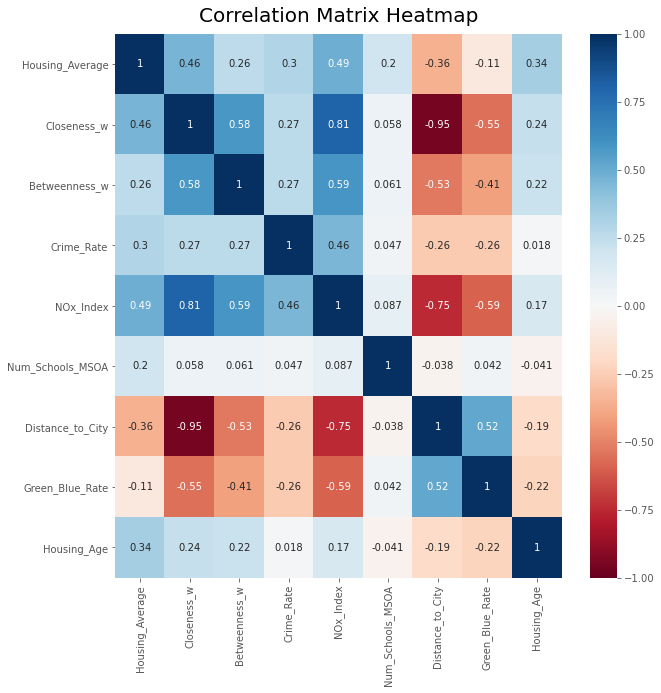

In [70]:
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap = 'RdBu')

heatmap.set_title('Correlation Matrix Heatmap', fontdict={'fontsize':20}, pad=12);

## Basic Plotting

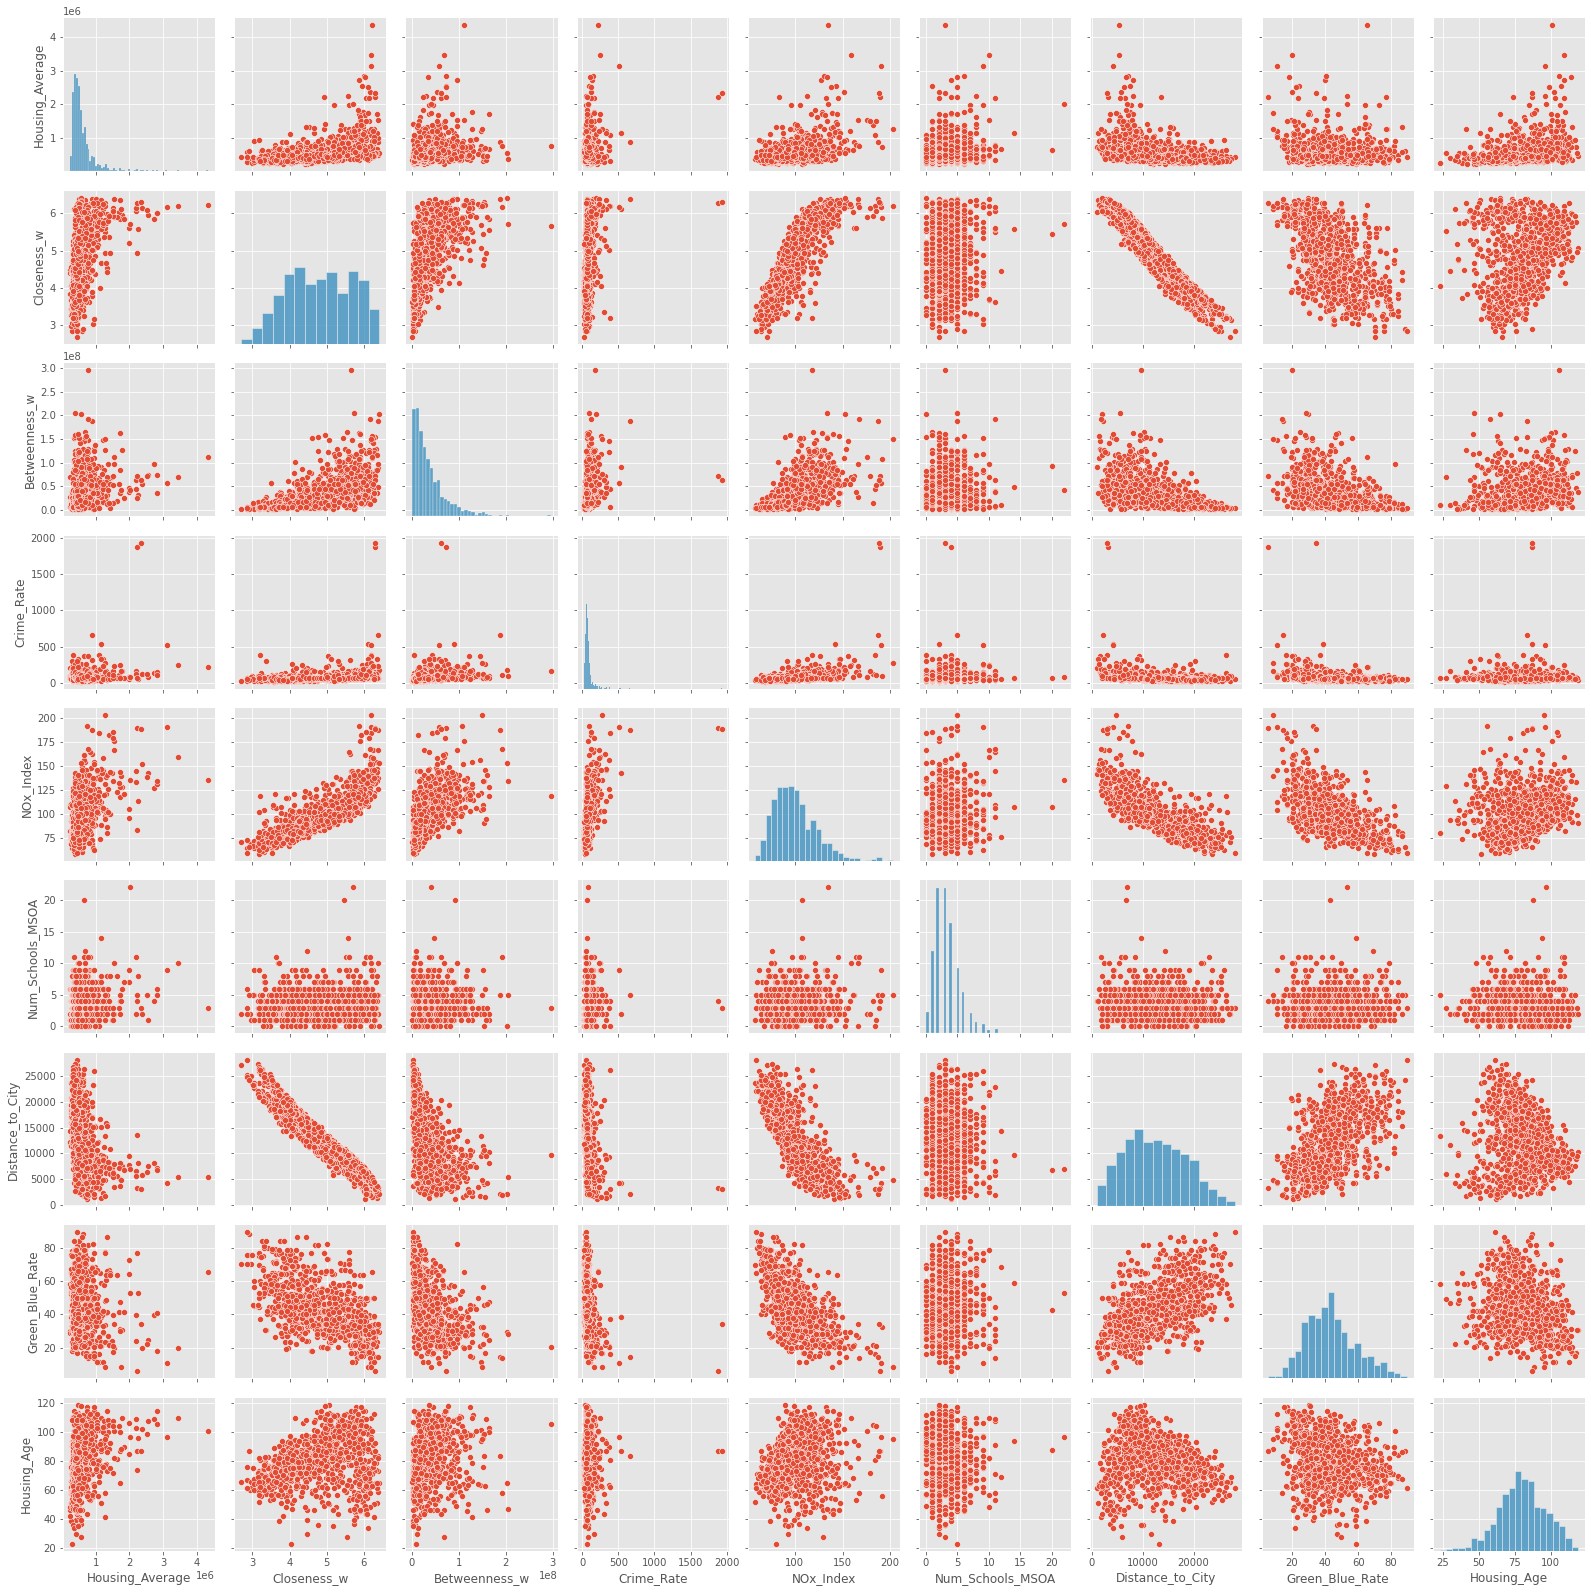

In [32]:
sns.pairplot(df)
plt.show()

## Regression

In [33]:
model = sm.formula.ols('Housing_Average ~ CC_w_MSOA + BC_w_MSOA + crime_rate + NOx_index + Num_Schools_MSOA + E02000001 + percent_green_blue + AVERAGE_AGE', df).fit()
model.summary()

PatsyError: Error evaluating factor: NameError: name 'AVERAGE_AGE' is not defined
    Housing_Average ~ CC_w_MSOA + BC_w_MSOA + crime_rate + NOx_index + Num_Schools_MSOA + E02000001 + percent_green_blue + AVERAGE_AGE
                                                                                                                           ^^^^^^^^^^^

In [ ]:
p_value    = model.f_pvalue
R_squared  = model.rsquared
print("R_squared  =", R_squared)
print("p_value    =", p_value)

### Regression with log 

In [ ]:
model = sm.formula.ols('Housing_Average.apply(np.log) ~ CC_w_MSOA + BC_w_MSOA + crime_rate + NOx_index + Num_Schools_MSOA + E02000001 + percent_green_blue + AVERAGE_AGE', df).fit()
model.summary()

### VIF

In [ ]:
def vif(df, col_i):
    """
    df: 整份数据
    col_i：被检测的列名
    """
    cols = list(df.columns)
    cols.remove(col_i)
    cols_noti = cols
    formula = col_i + '~' + '+'.join(cols_noti)
    r2 = ols(formula, df).fit().rsquared
    return 1. / (1. - r2)

In [ ]:
df_vif = df.drop(['Code','Area'], axis = 1)

In [ ]:
from statsmodels.formula.api import ols

for i in df_vif.columns:
    print(i, '\t', vif(df=df_vif, col_i=i))

In [ ]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [ ]:
drop_column_using_vif_

In [ ]:
# using VIF on the new_obesity_VIF_Process_1 dataset
df_vif_remain = drop_column_using_vif_(df_vif.drop('E02000001', axis=1))

print("The columns remaining after VIF selection are:")
print(df_vif_remain.columns)

### Regression again

#### Normal

In [ ]:
model = sm.formula.ols('Housing_Average ~ CC_w_MSOA + BC_w_MSOA + crime_rate + NOx_index + Num_Schools_MSOA + percent_green_blue + AVERAGE_AGE', df_vif_remain).fit()
model.summary()

#### After Log

In [ ]:
model = sm.formula.ols('Housing_Average.apply(np.log) ~ CC_w_MSOA + BC_w_MSOA + crime_rate + NOx_index + Num_Schools_MSOA + percent_green_blue + AVERAGE_AGE', df_vif_remain).fit()
model.summary()

### Residuals

In [ ]:
plt.scatter(model.fittedvalues, model.resid) # x and y all log
# adding title and labels
plt.xlabel('Fitted Housing Price')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Housing Price')
plt.show()

In [ ]:
plt.figure()
#ols.fit().model is a method to access to the residual.
model.resid.plot.density()
plt.title('Distribution of Residuals')
plt.show()